In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [101]:
path="../dataframes"
csvs = os.listdir(path)

datasets = []
for csv_name in csvs:
    dataset = pd.read_csv(f'{path}/{csv_name}', header=None)
    datasets.append(dataset)
    # break

In [102]:
themes_selected = ['anxiety', 'political']
restriction = True
equalize = True
max_samples_per_label = 500

def sample_restristion(sample: str):
    if sample in themes_selected:
        return True
    else:
        return False

def equilize_dataset(labels_count, sample: int):
    if labels_count[sample] < max_samples_per_label:
        labels_count[sample] += 1
        return labels_count, True
    else:
        return labels_count, False

In [103]:
def pre_process_dataset(dataset):
    X = dataset.iloc[:, :-1].values
    y = dataset.iloc[:, -1].values

    if restriction:
        indexes = [i for i, sample in enumerate(y) if sample_restristion(sample)]
        X = X[indexes]
        y = y[indexes]

    X = StandardScaler().fit_transform(X)
    y = pd.factorize(y)[0]


    if equalize:
        labels_count = [0] * 9
        indexes = []
        for i, sample in enumerate(y):
            labels_count, check = equilize_dataset(labels_count, sample)
            if check:
                indexes.append(i)
        
        X = X[indexes]
        y = y[indexes]


    data, labels = X, y
    (n_samples, n_features), n_digits = data.shape, np.unique(labels).size

    print(f"# labels: {n_digits}; # samples: {n_samples}; # features {n_features}")
    return data, labels, n_digits

In [104]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [fit_time]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]
    
    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:.3f}s\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    return results

In [105]:
def get_results(data, labels, n_digits):
    results = []
    print(82 * "_")
    print("time\thomo\tcompl\tv-meas\tARI\tsilhouette")

    kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
    results.extend(bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels))

    kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
    results.extend(bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels))

    pca = PCA(n_components=n_digits).fit(data)
    kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
    results.extend(bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels))

    print(82 * "_")
    return results

In [106]:

def plot_pca(data, labels, n_digits, model_name):
    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(
        Z,
        interpolation="nearest",
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        cmap=plt.cm.Paired,
        aspect="auto",
        origin="lower",
    )

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        marker="x",
        s=169,
        linewidths=3,
        color="w",
        zorder=10,
    )
    plt.title(
        f"K-Means na base de dados gerada pelo modelo {model_name} (Dados após PCA)"
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.savefig(f'{model_name}.png')
    plt.show()

In [107]:
def pipeline(model_name, dataset):
    data, labels, n_digits = pre_process_dataset(dataset)
    results = get_results(data, labels, n_digits)
    plot_pca(data, labels, n_digits, model_name)
    print(results)
    return results

# labels: 2; # samples: 1000; # features 30
__________________________________________________________________________________
time	homo	compl	v-meas	ARI	silhouette
0.024s	0.393	0.413	0.403	0.438	0.137
0.020s	0.403	0.422	0.412	0.451	0.136
0.007s	0.772	0.773	0.772	0.850	0.095
__________________________________________________________________________________


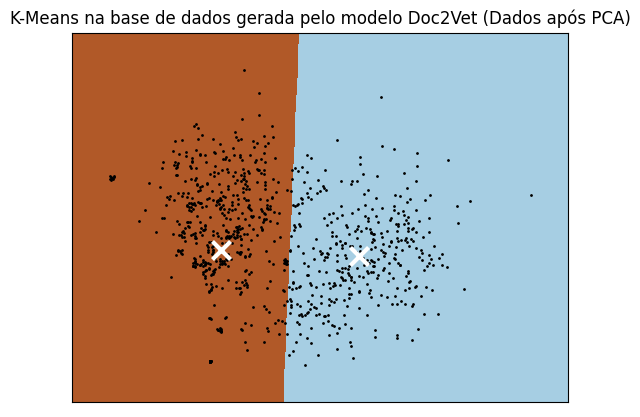

[0.023970842361450195, 0.3927327744942402, 0.4134459317828264, 0.40282326146337416, 0.4377197927480427, 0.13707005849594334, 0.020000219345092773, 0.4028103890323631, 0.42236860729677983, 0.41235771578560865, 0.4510694141161583, 0.1364943815950292, 0.006996631622314453, 0.7716313162468292, 0.7728113296790015, 0.7722208721751493, 0.8499341017429266, 0.09507374440368832]
# labels: 2; # samples: 1000; # features 4096
__________________________________________________________________________________
time	homo	compl	v-meas	ARI	silhouette
0.232s	0.010	0.010	0.010	0.012	0.398
0.182s	0.010	0.010	0.010	0.012	0.383
0.121s	0.010	0.010	0.010	0.012	0.382
__________________________________________________________________________________


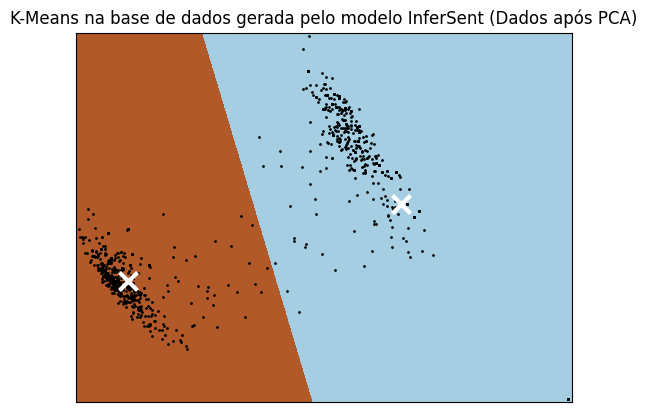

[0.23200035095214844, 0.009729755591356337, 0.009730766389662157, 0.009730260964258327, 0.012467621447557626, 0.3982847770251186, 0.18200325965881348, 0.009729755591356337, 0.009730766389662157, 0.009730260964258327, 0.012467621447557626, 0.3830784943199874, 0.12100028991699219, 0.009729755591356337, 0.009730766389662157, 0.009730260964258327, 0.012467621447557626, 0.38240282123804187]
# labels: 2; # samples: 1000; # features 768
__________________________________________________________________________________
time	homo	compl	v-meas	ARI	silhouette
0.085s	0.128	0.246	0.169	0.054	0.368
0.046s	0.128	0.246	0.169	0.054	0.378
0.027s	0.128	0.246	0.169	0.054	0.407
__________________________________________________________________________________


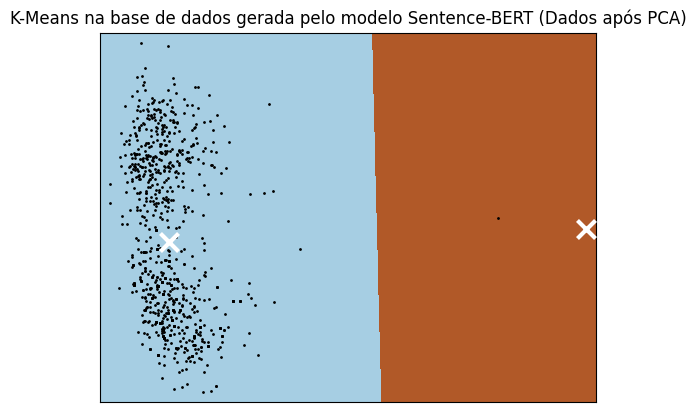

[0.08495211601257324, 0.12821588399470663, 0.24624910582049833, 0.16863016647437326, 0.05436483077089799, 0.36778631906751486, 0.04600048065185547, 0.12821588399470663, 0.24624910582049833, 0.16863016647437326, 0.05436483077089799, 0.378491686202159, 0.027000904083251953, 0.12821588399470663, 0.24624910582049833, 0.16863016647437326, 0.05436483077089799, 0.4066085610278283]
# labels: 2; # samples: 1000; # features 512
__________________________________________________________________________________
time	homo	compl	v-meas	ARI	silhouette
0.036s	0.133	0.250	0.174	0.058	0.228
0.032s	0.133	0.250	0.174	0.058	0.243
0.026s	0.852	0.853	0.852	0.914	0.084
__________________________________________________________________________________


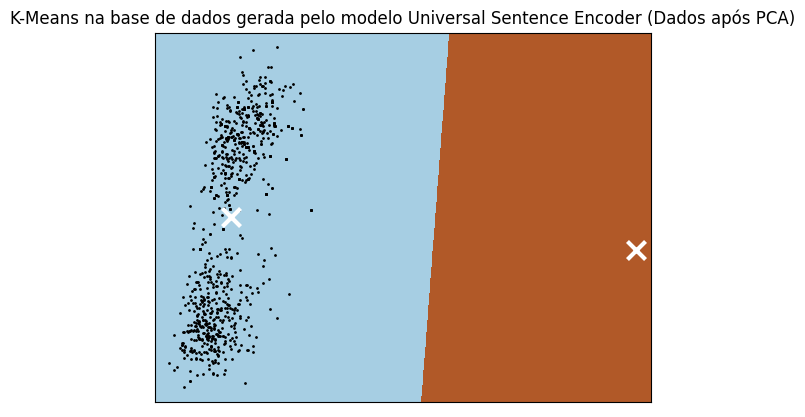

[0.035999298095703125, 0.1330533096268341, 0.24999282203372028, 0.17367293182333912, 0.05816290750221833, 0.22818696685185869, 0.03200125694274902, 0.1330533096268341, 0.24999282203372028, 0.17367293182333912, 0.05816290750221833, 0.2434746877015176, 0.026000499725341797, 0.8521523619313329, 0.8525066091761674, 0.8523294487454757, 0.9138498132490056, 0.08373828324095231]


In [108]:
results = []
models_name = ['Doc2Vet', 'InferSent', 'Sentence-BERT', 'Universal Sentence Encoder']
for i, dataset in enumerate(datasets):
    model_name = models_name[i]
    results.extend(pipeline(model_name, dataset))

In [109]:
formatter_result = (
"\\begin{{table}}[H] \n\
\\centering \n\
\\resizebox{{\\textwidth}}{{!}}{{% \n\
\\begin{{tabular}}{{@{{}}llllllll@{{}}}} \n\
\\toprule \n\
Modelo                                      & Inicialização  & Tempo & Homo & Compl & V-Measure & IRA & Silhouette \\\ \midrule \n\
\\multirow{{3}}{{*}}{{Doc2Vet}}                    & k-means++      &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \cmidrule(l){{2-8}} \n\
                                            & aleatória      &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \cmidrule(l){{2-8}} \n\
                                            & baseada em PCA &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \midrule \n\
\\multirow{{3}}{{*}}{{InferSent}}                  & k-means++      &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \cmidrule(l){{2-8}} \n\
                                            & aleatória      &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \cmidrule(l){{2-8}} \n\
                                            & baseada em PCA &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \midrule \n\
\\multirow{{3}}{{*}}{{Sentence-BERT}}              & k-means++      &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \cmidrule(l){{2-8}} \n\
                                            & aleatória      &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \cmidrule(l){{2-8}} \n\
                                            & baseada em PCA &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \midrule \n\
\\multirow{{3}}{{*}}{{Universal Sentence Encoder}} & k-means++      &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \cmidrule(l){{2-8}} \n\
                                            & aleatória      &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \cmidrule(l){{2-8}} \n\
                                            & baseada em PCA &   {:.3f}s    &   {:.3f}  &   {:.3f}    &      {:.3f}     &  {:.3f}   &     {:.3f}       \\\ \\bottomrule \n\
\end{{tabular}}% \n\
}} \n\
\\caption{{}} \n\
\\label{{tab:my-table}} \n\
\\end{{table}}" 
)
print(formatter_result.format(*results))

\begin{table}[H] 
\centering 
\resizebox{\textwidth}{!}{% 
\begin{tabular}{@{}llllllll@{}} 
\toprule 
Modelo                                      & Inicialização  & Tempo & Homo & Compl & V-Measure & IRA & Silhouette \\ \midrule 
\multirow{3}{*}{Doc2Vet}                    & k-means++      &   0.024s    &   0.393  &   0.413    &      0.403     &  0.438   &     0.137       \\ \cmidrule(l){2-8} 
                                            & aleatória      &   0.020s    &   0.403  &   0.422    &      0.412     &  0.451   &     0.136       \\ \cmidrule(l){2-8} 
                                            & baseada em PCA &   0.007s    &   0.772  &   0.773    &      0.772     &  0.850   &     0.095       \\ \midrule 
\multirow{3}{*}{InferSent}                  & k-means++      &   0.232s    &   0.010  &   0.010    &      0.010     &  0.012   &     0.398       \\ \cmidrule(l){2-8} 
                                            & aleatória      &   0.182s    &   0.010  &   0.010    &      0.010